In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import display

# Data Structure (for reference)

In [28]:
import re, collections
from lxml import etree

x =  open("Scrutins_XIV.xml")
xml = x.read()

xml_root = etree.fromstring(xml)
raw_tree = etree.ElementTree(xml_root)
nice_tree = collections.OrderedDict()
 
for tag in xml_root.iter():
    path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
    if path not in nice_tree:
        nice_tree[path] = []
    if len(tag.keys()) > 0:
        nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
for path, attribs in nice_tree.items():
    indent = int(path.count('/') - 1)
    print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) if len(attribs) > 0 else '-'))

0: scrutins [-]
    1: scrutin [-]
        2: uid [-]
        2: numero [-]
        2: organeRef [-]
        2: legislature [-]
        2: sessionRef [-]
        2: seanceRef [-]
        2: dateScrutin [-]
        2: quantiemeJourSeance [-]
        2: typeVote [-]
            3: codeTypeVote [-]
            3: libelleTypeVote [-]
            3: typeMajorite [-]
        2: sort [-]
            3: code [-]
            3: libelle [-]
        2: titre [-]
        2: demandeur [-]
            3: texte [-]
            3: referenceLegislative [{http://www.w3.org/2001/XMLSchema-instance}nil]
        2: objet [-]
            3: libelle [-]
            3: referenceLegislative [{http://www.w3.org/2001/XMLSchema-instance}nil]
        2: modePublicationDesVotes [-]
        2: syntheseVote [-]
            3: nombreVotants [-]
            3: suffragesExprimes [-]
            3: nbrSuffragesRequis [-]
            3: annonce [-]
            3: decompte [-]
                4: pour [-]
                4:

In [4]:
import xml.etree.ElementTree as ET
tree = ET.parse('Scrutins_XIV.xml')
root = tree.getroot()

In [5]:
all_dates = [root.getchildren()[i].getchildren()[6].text for i in np.arange(len(root.getchildren()))]
all_dates = pd.to_datetime(all_dates, yearfirst = True)
all_uid = [root.getchildren()[i].getchildren()[0].text for i in np.arange(len(root.getchildren()))]
all_quantiemejour = [root.getchildren()[i].getchildren()[7].text for i in np.arange(len(root.getchildren()))]

In [6]:
df = pd.DataFrame(data = [all_dates, all_uid, all_quantiemejour]
                 ).transpose().rename(columns = {0:'Date', 1:'UID', 2:'Nth_day'})
df.head()

,Date,UID,Nth_day
0,2012-07-03 00:00:00,VTANR5L14V1,1
1,2012-07-17 00:00:00,VTANR5L14V2,1
2,2012-07-18 00:00:00,VTANR5L14V3,1
3,2012-07-18 00:00:00,VTANR5L14V4,1
4,2012-07-18 00:00:00,VTANR5L14V5,2


The French National Assembly is not in session everyday, and may have more than 1 vote on any given day. Let's compute the average number of vote.

In [7]:
len(df['Date']) / len(df['Date'].unique())

3.6300268096514747

Almost 4 votes on each working day... Let's explore the National Assembly's "busyness" over time.

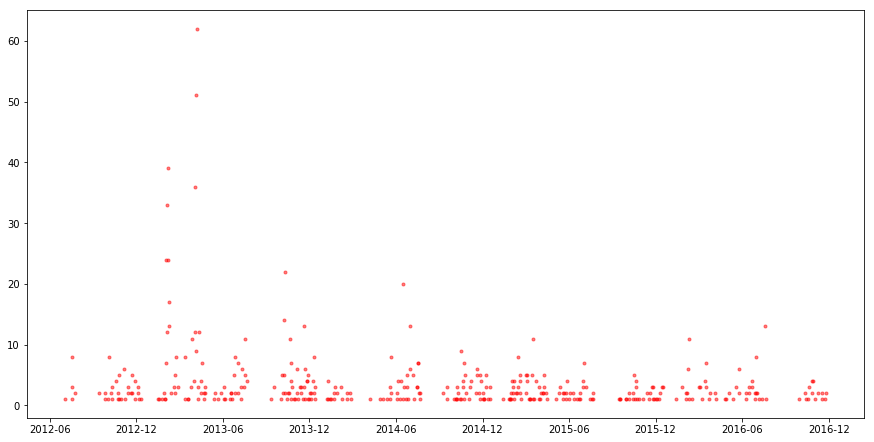

In [8]:
count_votes = df.groupby(by = 'Date', as_index= False).agg("count")
plt.figure(figsize=(15, 7.5))
plt.plot_date(x = count_votes.iloc[:, 0], y = count_votes.iloc[:, 1], fmt='o',
              alpha = .5, ms = 3, color = "red");

Investigate outliers... Could this have to do with "the 100 days" cliché where most new Presidents reform more during their first days in office?

In [9]:
count_votes.loc[count_votes['UID'] > 20, :]

,Date,UID,Nth_day
39,2013-02-02,24,24
40,2013-02-03,33,33
42,2013-02-05,24,24
43,2013-02-06,39,39
60,2013-04-04,36,36
61,2013-04-05,51,51
63,2013-04-08,62,62
105,2013-10-11,22,22


The number of political groups can change due to shifting alliances.

In [11]:
# how many groups?
number_groups = [len(root.getchildren()[i].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren()) for i in np.arange(len(root.getchildren()))]

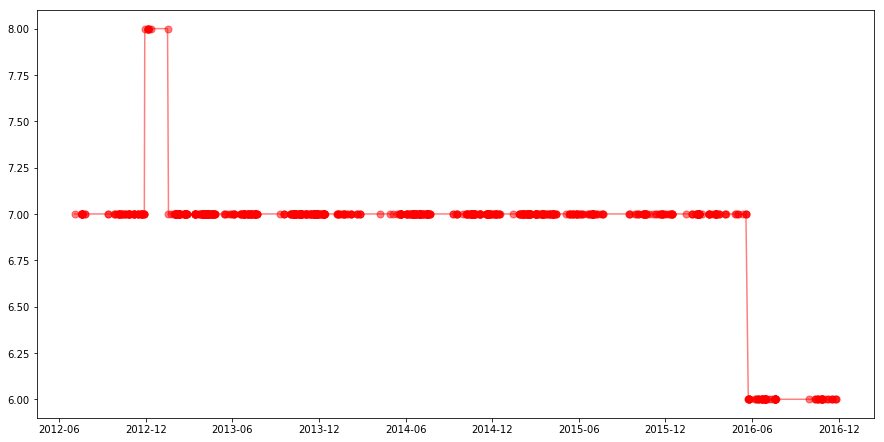

In [12]:
plt.figure(figsize=(15, 7.5))
plt.plot_date(y = number_groups, x = all_dates, fmt='-o',
              alpha = .5, ms = 7, color = "red");

> Groupe du Rassemblement-UMP (R-UMP) est un ancien groupe qui avait fait scission du groupe UMP. Il est créé le 27 novembre 2012 à l'initiative de François Fillon à la suite des résultats contestés du congrès de l'UMP. Trois députés du parti radical élus avec l'étiquette de l'UMP, Jean Leonetti, Alain Marc, Frédéric Reiss, et l'unique député du Parti chrétien-démocrate (PCD), Dino Cinieri, font partie des 68 à rejoindre le groupe dès sa formation8. Le président du groupe est François Fillon. Il regroupe finalement 72 députés dont 3 apparenté. À la suite de l'accord trouvé entre François Fillon et Jean-François Copé, le groupe est dissous le 15 janvier 2013 et les députés rejoignent le groupe UMP.

> Depuis mai 2016, avec la disparition du groupe ÉCOLO, plusieurs députés EÉLV sont non-inscrits.

In [13]:
num_deputes_PS = [root.getchildren()[i].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren()[0].getchildren()[1].text for i in np.arange(len(root.getchildren()))]
num_deputes_PS = np.array(list(map(int, num_deputes_PS)))

num_deputes_UMP = [root.getchildren()[i].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren()[1].getchildren()[1].text for i in np.arange(len(root.getchildren()))]
num_deputes_UMP = np.array(list(map(int, num_deputes_UMP)))

diff = num_deputes_PS - num_deputes_UMP
diff

array([98, 99, 99, ..., 89, 89, 89])

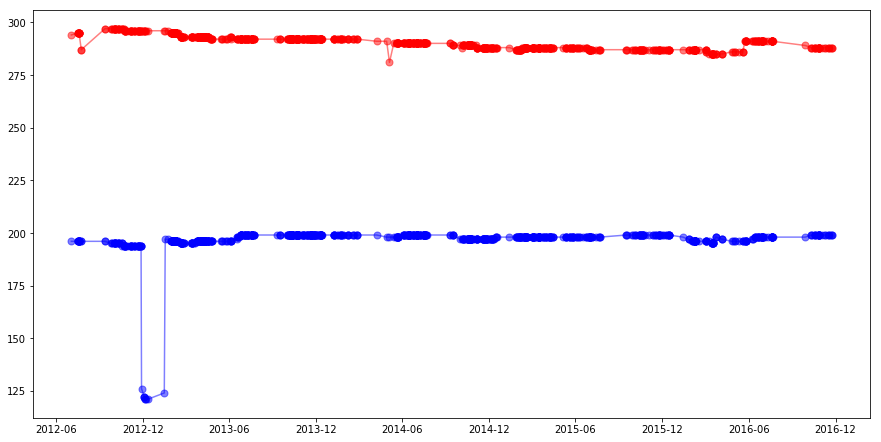

In [14]:
plt.figure(figsize=(15, 7.5))
plt.plot_date(y = num_deputes_UMP, x = all_dates, fmt='-o',
              alpha = .5, ms = 7, color = "blue");
plt.plot_date(y = num_deputes_PS, x = all_dates, fmt='-o',
              alpha = .5, ms = 7, color = "red");

#### Looking at the results of each ballot

In [15]:
num_voting = [int(root.getchildren()[i].getchildren()[-3].getchildren()[0].text) for i in np.arange(len(root.getchildren()))]

In [16]:
suf_expr = [int(root.getchildren()[i].getchildren()[-3].getchildren()[1].text) for i in np.arange(len(root.getchildren()))]

In [17]:
titres = [root.getchildren()[i].getchildren()[10].text for i in np.arange(len(root.getchildren()))]
result = [root.getchildren()[i].getchildren()[9].getchildren()[0].text for i in np.arange(len(root.getchildren()))]
origin = [root.getchildren()[i].getchildren()[11].getchildren()[0].text for i in np.arange(len(root.getchildren()))]

In [18]:
titres = [root.getchildren()[i].getchildren()[10].text for i in np.arange(len(root.getchildren()))]

In [19]:
pour = [int(root.getchildren()[i].getchildren()[-3].getchildren()[4].getchildren()[0].text) for i in np.arange(len(root.getchildren()))]
contre = [int(root.getchildren()[i].getchildren()[-3].getchildren()[4].getchildren()[1].text) for i in np.arange(len(root.getchildren()))]
abst = [int(root.getchildren()[i].getchildren()[-3].getchildren()[4].getchildren()[2].text) for i in np.arange(len(root.getchildren()))]
no_vote = [int(root.getchildren()[i].getchildren()[-3].getchildren()[4].getchildren()[3].text) for i in np.arange(len(root.getchildren()))]

In [20]:
vote_results = pd.DataFrame(data = [all_dates, all_uid, titres, num_voting, suf_expr, pour, contre, abst, no_vote, result, origin]
                           ).transpose().rename(columns = {0:'date', 1:'UID', 2:'titre', 3:'num_voting', 
                                                           4:'suf_expr', 5:'pour', 6:'contre', 7:'abst',
                                                           8:'no_vote', 9:'result', 10:'origin'}).fillna(value='None', inplace = False)
vote_results.head()

,date,UID,titre,num_voting,suf_expr,pour,contre,abst,no_vote,result,origin
0,2012-07-03,VTANR5L14V1,la déclaration de politique générale du gouver...,544,527,302,225,17,26,adopté,Conférence des présidents
1,2012-07-17,VTANR5L14V2,l'article 1er du projet de loi de finances rec...,110,109,61,48,1,27,adopté,Président du groupe de l'union pour un mouveme...
2,2012-07-18,VTANR5L14V3,les amendements de suppression de l'article 2 ...,260,259,81,178,1,26,rejeté,Président du groupe de l'union pour un mouveme...
3,2012-07-18,VTANR5L14V4,les amendements de suppression de l'alinéa 2 à...,265,265,88,177,0,27,rejeté,Président du groupe de l'union pour un mouveme...
4,2012-07-18,VTANR5L14V5,l'article 2 du projet de loi de finances recti...,153,153,89,64,0,26,adopté,Président du groupe de l'union pour un mouveme...


NB : abstention n'est pas comptée dans les 'suffrages_exprimés', mais est compté dans le nombre de votants.

In [21]:
vote_results['prop_pour'] = vote_results['pour'] / vote_results['suf_expr']
vote_results['prop_contre'] = vote_results['contre'] / vote_results['suf_expr']

In [22]:
adopte = vote_results.loc[vote_results['result'] == 'adopté', :]
rejete = vote_results.loc[vote_results['result'] == 'rejeté', :]

In [23]:
adopte.shape[0], rejete.shape[0]
# more rejection than adoption

(427, 927)

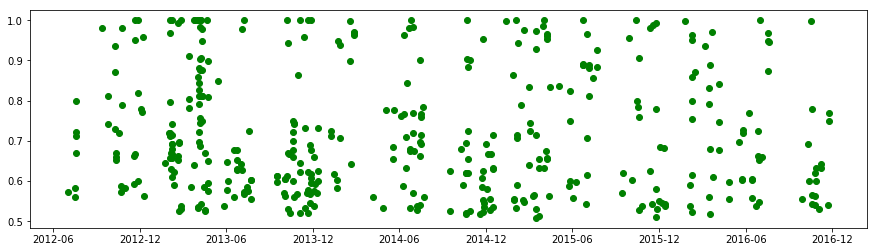

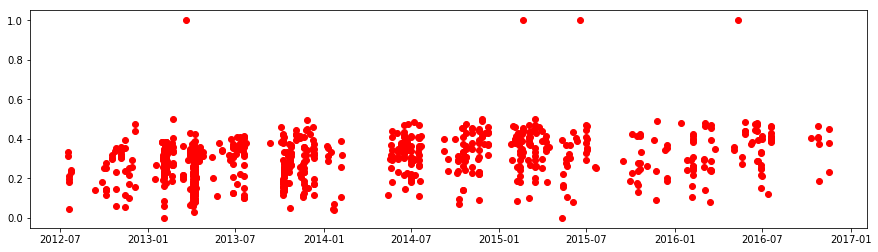

In [24]:
plt.figure(figsize=(15, 4))
plt.plot_date(x = adopte['date'], y = adopte['prop_pour'], color = 'green');
plt.figure(figsize=(15, 4))
plt.plot_date(x = rejete['date'], y = rejete['prop_pour'], color = 'red');

**Outliers in red are '49.3'. Each is a 'motion de censure' from the opposition!**

In [23]:
rejete.loc[rejete['prop_pour'] == 1, :]

,date,UID,titre,num_voting,suf_expr,pour,contre,abst,no_vote,result,origin,prop_pour,prop_contre
291,2013-03-20,VTANR5L14V292,la motion de censure déposée en application de...,228,228,228,0,0,1,rejeté,Conférence des présidents,1.0,0.0
1043,2015-02-19,VTANR5L14V1044,la motion de censure déposée en application de...,234,234,234,0,0,1,rejeté,Conférence des présidents,1.0,0.0
1132,2015-06-18,VTANR5L14V1133,la motion de censure déposée en application de...,198,198,198,0,0,3,rejeté,Conférence des présidents,1.0,0.0
1269,2016-05-12,VTANR5L14V1270,la motion de censure déposée par MM. Christian...,246,246,246,0,0,1,rejeté,None,1.0,0.0


In [27]:
adopte.loc[adopte['prop_pour'] == 1, :].head()

,date,UID,titre,num_voting,suf_expr,pour,contre,abst,no_vote,result,origin,prop_pour,prop_contre
65,2012-11-22,VTANR5L14V66,l'ensemble de la proposition de loi visant à ...,90,90,90,0,0,2,adopté,Président du groupe de l'union des démocrates ...,1.0,0.0
73,2012-11-27,VTANR5L14V74,l'ensemble du projet de loi relatif à la sécur...,46,45,45,0,1,2,adopté,Président du groupe de l'union pour un mouveme...,1.0,0.0
103,2013-02-02,VTANR5L14V104,l'amendement n° 17 de M. Pélissard après l'art...,275,275,275,0,0,1,adopté,Président du groupe de l'union pour un mouveme...,1.0,0.0
247,2013-02-08,VTANR5L14V248,l'amendement n° 2247 de M. Mariton et les amen...,93,93,93,0,0,2,adopté,Président du groupe de l'union pour un mouveme...,1.0,0.0
280,2013-02-26,VTANR5L14V281,l'ensemble de la proposition de loi relative a...,469,461,461,0,8,1,adopté,Conférence des présidents,1.0,0.0


# Origin of each vote
### Needs a lot of cleaning...

In [109]:
#vote_results[['origin', 'UID']].groupby('origin').count().sort_values(by = 'UID', ascending = False)["UID"]

opp = ["Président du groupe de l'union pour un mouvement populaire",
 "Président du groupe Les Républicains", 
 "Président du groupe Les Républicains\n\nPrésident du groupe de l'union des démocrates et indépendants",
 "Président du groupe de l'union des démocrates et indépendants", "UMP"] # UMP, then LR

fl = ["Président du groupe de la gauche démocrate et républicaine"] # far-left

maj = ["Président du groupe socialiste, républicain et citoyen",
 "Président du groupe socialiste, écologiste et républicain"
 "Président du groupe radical, républicain, démocrate et progressiste", "Gouvernement"] # Majorité Présidentielle

eco = ["Président du groupe écologiste"] # Green party

pdt = ['Conférence des présidents']

In [113]:
vote_results['right'] = 0
vote_results['farleft'] = 0
vote_results['maj'] = 0
vote_results['eco'] = 0
vote_results['pdt'] = 0
vote_results['other'] = 0

In [115]:
for t in times:
    if (t % 100 == 0):
        print(t)
    if (vote_results['origin'][t] in opp):
        vote_results['right'][t] = 1
        
    elif (vote_results['origin'][t] in fl):
        vote_results['farleft'][t] = 1
        
    elif (vote_results['origin'][t] in maj):
        vote_results['maj'][t] = 1
        
    elif (vote_results['origin'][t] in eco):
        vote_results['eco'][t] = 1
        
    elif (vote_results['origin'][t] in pdt):
        vote_results['pdt'][t] = 1
        
    else: vote_results['other'][t] = 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


### Histogram of ballot outcome by ballot proponents (Right wing in Brown, Left wing (majority) in Blue, _Conference des Presidents_ in Green)

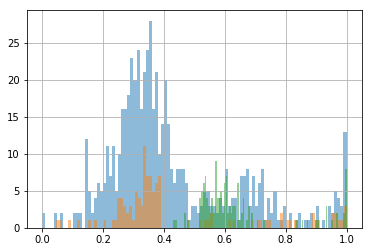

In [125]:
vote_results[vote_results['right'] == 1]['prop_pour'].hist(bins = 100, alpha = .5);
vote_results[vote_results['maj'] == 1]['prop_pour'].hist(bins = 100, alpha = .5);
vote_results[vote_results['pdt'] == 1]['prop_pour'].hist(bins = 100, alpha = .5);

# Analysis of Results

In [55]:
vote_results.head()

,date,UID,titre,num_voting,suf_expr,pour,contre,abst,no_vote,result,origin,prop_pour,prop_contre
0,2012-07-03,VTANR5L14V1,la déclaration de politique générale du gouver...,544,527,302,225,17,26,adopté,Conférence des présidents,0.573055,0.426945
1,2012-07-17,VTANR5L14V2,l'article 1er du projet de loi de finances rec...,110,109,61,48,1,27,adopté,Président du groupe de l'union pour un mouveme...,0.559633,0.440367
2,2012-07-18,VTANR5L14V3,les amendements de suppression de l'article 2 ...,260,259,81,178,1,26,rejeté,Président du groupe de l'union pour un mouveme...,0.312741,0.687259
3,2012-07-18,VTANR5L14V4,les amendements de suppression de l'alinéa 2 à...,265,265,88,177,0,27,rejeté,Président du groupe de l'union pour un mouveme...,0.332075,0.667925
4,2012-07-18,VTANR5L14V5,l'article 2 du projet de loi de finances recti...,153,153,89,64,0,26,adopté,Président du groupe de l'union pour un mouveme...,0.581699,0.418301


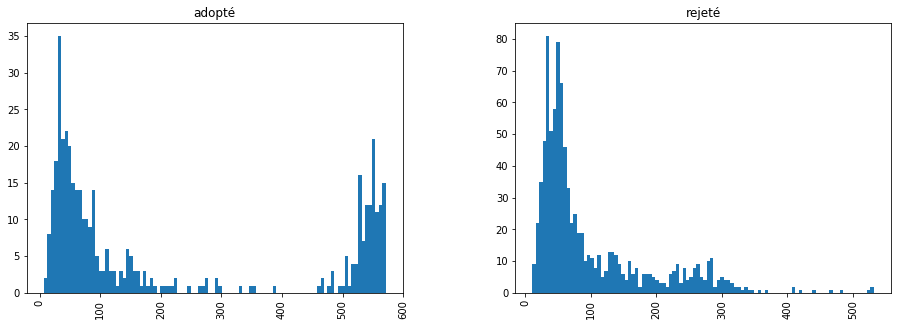

In [28]:
vote_results['num_voting'].hist(bins = 100, by = vote_results['result'], figsize = (15, 5));

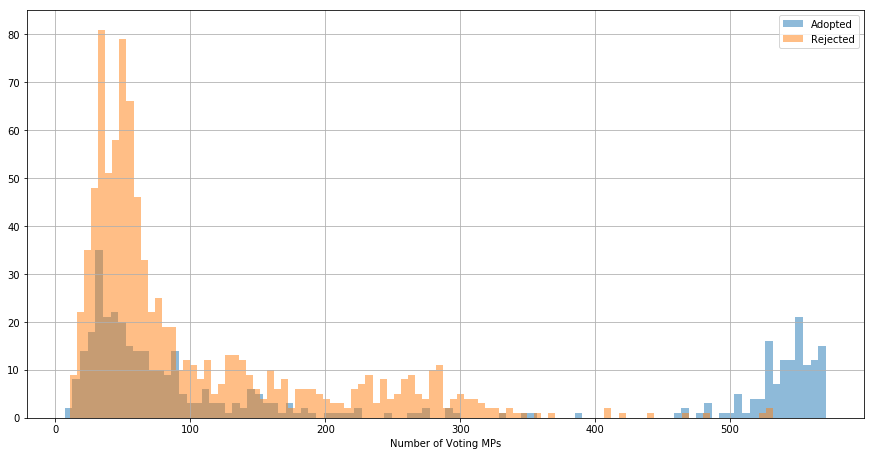

In [29]:
adopte['num_voting'].hist(bins = 100, alpha = .5, figsize = (15, 7.5), label = 'Adopted');
rejete['num_voting'].hist(bins = 100, alpha = .5, label = 'Rejected');
plt.xlabel('Number of Voting MPs');
plt.legend();

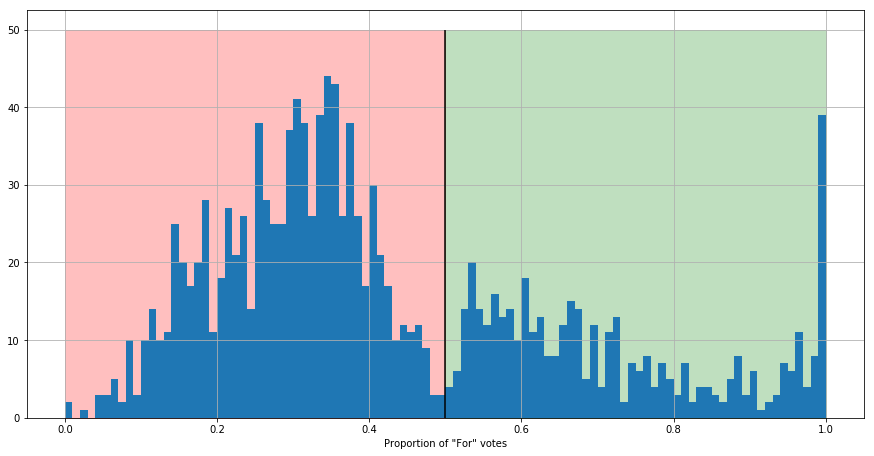

In [30]:
vote_results['prop_pour'].hist(bins = 100, alpha = 1, figsize = (15, 7.5));
plt.vlines(x = .5, ymin = 0, ymax = 50);
plt.fill_betweenx(y = np.linspace(0, 50), x1 = .5, alpha = .25, color = 'red');
plt.fill_betweenx(y = np.linspace(0, 50), x1 = .5, x2 = 1, alpha = .25, color = 'green');
plt.xlabel('Proportion of "For" votes');